In [36]:
import sympy as sp
sp.init_printing()
import numpy as np
import scipy.integrate
import math, cmath, datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
tStart = datetime.datetime.now()

FP = "0A0_S_15_sc_0.50_U35_F02_A02_"

Stag = float(FP[6:8])*math.pi/180
s_c = float(FP[12:16])
U_1 = float(FP[18:20])
Freq = float(FP[22:24])
Amp = float(FP[26:28])

p_1 = 0
rho_1 = 1.225
ibpa_all = np.linspace(0,360,14,endpoint=False)
ibpa_all[0] = 1
delX = s_c*np.sin(Stag)
q_1 = 0.5 * rho_1 * U_1**2

#ibpa_all = [180]   # run one loop; for diagnostics

print([Stag, s_c, U_1, Freq, Amp])


[0.2617993877991494, 0.5, 35.0, 2.0, 2.0]


In [37]:
def getA_s(x, t):
    x_closest = min(np.ndarray.tolist(X), key=lambda y:abs(y-x))
    col = np.ndarray.tolist(X).index(x_closest)
    row = np.ndarray.tolist(T).index(t)
    D = DS
    return D[row,col]

def getA_p(x, t):
    x_closest = min(np.ndarray.tolist(X), key=lambda y:abs(y-x))
    col = np.ndarray.tolist(X).index(x_closest)
    row = np.ndarray.tolist(T).index(t)
    D = DP
    return D[row,col]

def pres_s(x, t):
    '''provides the value of pressure for a given
                location  : x
                    time  : t
       on the SUCTION surface only'''
    A_1 = getA_s(delX - 0.5, t)
    A   = getA_s(x, t)
    p = q_1 - 0.5*rho_1*(U_1*A_1/A)**2
    if x > -0.5 + delX:
        pres = p
    else:
        pres = p_1
    return(pres)

def pres_p(x, t):
    '''provides the value of pressure for a given
                location  : x
                    time  : t
       on the PRESSURE surface only'''
    A_1 = getA_p(-0.5, t)
    A_2 = getA_p(0.5 - delX, t)
    A   = getA_p(x, t)
    p = q_1 - 0.5*rho_1*(U_1*A_1/A)**2
    p_2 = q_1 - 0.5*rho_1*(U_1*A_1/A_2)**2
    if x < 0.5 - delX:
        pres = p
    else:
        pres = p_2
    return(pres)


class Fanalysis:
    def __init__(self, tVect, sVect):
        self.tVect = tVect
        self.sVect = sVect
    
    def CompCoeffs(self):
        self.Mfft = np.fft.fft(self.sVect - np.mean(self.sVect))
        self.Fvec = np.linspace(0,1/(self.tVect[1] - self.tVect[0]),len(self.sVect))
        self.Mmag = abs(self.Mfft)*2/len(self.sVect)
        self.Mphs = np.arctan2(np.imag(self.Mfft) , np.real(self.Mfft))*180/np.pi
    
    def HarmsOf(self, FreqOsc):
        F_closest = min(np.ndarray.tolist(self.Fvec), key=lambda y:abs(y-FreqOsc))
        F_list = np.ndarray.tolist(self.Fvec)  # So we *can* use variables defined in other functions here. Hmm.
        self.ndx1 = F_list.index(F_closest)
        self.Fre1 = self.Fvec[self.ndx1]
        self.cm1m = self.Mmag[self.ndx1]
        self.cm1p = self.Mphs[self.ndx1]
        self.ndx2 = self.ndx1*2
        self.Fre2 = self.Fvec[self.ndx2]
        self.cm2m = self.Mmag[self.ndx2]
        self.cm2p = self.Mphs[self.ndx2]


with open(FP + "results.dat", "wb") as myfileRES:
    np.savetxt(myfileRES, ['IBPA(deg)\t Mag(c_mA1)\t Phs(c_mA1)\t Mag(c_mA2)\t Phs(c_mA2)'], fmt="%11s")
    myfileRES.write(b'\n')


    for ibpa in ibpa_all:

        ibpaRad = ibpa*math.pi/180
        sIBPA = "%05.1f" % ibpa

        with open(FP + "gap_suc_" + sIBPA + ".txt","r") as fnameS:
            D0S  = np.loadtxt(fnameS,skiprows=1)

        with open(FP + "gap_suc_" + sIBPA + ".txt","r") as fnameP:
            D0P = np.loadtxt(fnameP,skiprows=1)

        D1 = np.delete(D0S,[0, 1, 2, 3],1)
        DS = np.delete(D1,[0],0)
        X = D1[0,:]
        T, a0, am1, ap1 = D0S[1:,0], D0S[1:,1], D0S[1:,2], D0S[1:,3]

        D2 = np.delete(D0P,[0, 1, 2, 3],1)
        DP = np.delete(D2,[0],0)

        with open(FP + "y_C2_" + sIBPA + ".txt","r") as fnameS:
            Y0S  = np.loadtxt(fnameS,skiprows=1)

        YS = np.delete(np.delete(Y0S,[0, 1, 2, 3],1),[0],0)

        with open(FP + "y_C3_" + sIBPA + ".txt","r") as fnameP:
            Y0P = np.loadtxt(fnameP,skiprows=1)

        YP = np.delete(np.delete(Y0P,[0, 1, 2, 3],1),[0],0)

        with open(FP + "dy_C2_" + sIBPA + ".txt","r") as fnameS:
            dY0S  = np.loadtxt(fnameS,skiprows=1)

        dYS = np.delete(np.delete(dY0S,[0, 1, 2, 3],1),[0],0)

        with open(FP + "dy_C3_" + sIBPA + ".txt","r") as fnameP:
            dY0P = np.loadtxt(fnameP,skiprows=1)

        dYP = np.delete(np.delete(dY0P,[0, 1, 2, 3],1),[0],0)



        ## Construct pressure field

        M = np.empty_like(T)
        PS = np.empty_like(DS)
        PP = np.empty_like(DP)

        for r in range(len(DP[:,0])):
            t = T[r]
            for c in range(len(DP[0,:])):
                x = X[c]
                PS[r,c] = pres_s(x,t)
                PP[r,c] = pres_p(x,t)

        with open(FP + "P_suc_" + sIBPA + ".txt", "wb") as myfilePS:
            np.savetxt(myfilePS, PS, fmt="%+11.9e", delimiter='\t')

        with open(FP + "P_pre_" + sIBPA + ".txt", "wb") as myfilePS:
            np.savetxt(myfilePS, PP, fmt="%+11.9e", delimiter='\t')

        for r in range(len(T)):
            t = T[r]
            Yarray = PS[r,:]*(X + dYS[r,:]*YS[r,:]) - PP[r,:]*(X + dYP[r,:]*YP[r,:])
            M[r] = scipy.integrate.simps(Yarray, X)
        
        M = M/(Amp*q_1)

        with open(FP + "Moment_" + sIBPA + ".txt", "wb") as myfilePS:
            np.savetxt(myfilePS, M, fmt="%+11.9e", delimiter='\t')

        X_m, Y_m = np.meshgrid(X, T)
        lev = np.linspace(-200,200,11)
        
        sigM = Fanalysis(T, M)
        sigM.CompCoeffs()
        sigM.HarmsOf(Freq)


        with PdfPages('plots_' + FP + sIBPA + '.pdf') as pdf:
                plt.plot(T,M)
                #plt.ylim((5.5,8.5))
                plt.xlabel('Time (s)', fontsize=16)
                plt.ylabel('Moment (Nm)', fontsize=16)
                pdf.savefig()
                plt.close()

                plt.contourf(X_m, Y_m, PS, lev)
                cbar = plt.colorbar()
                cbar.ax.set_ylabel('p_s (Pa)')
                plt.suptitle('Pressure periodogram (suction surface)', fontsize=18)
                plt.xlabel('x/c location', fontsize=16)
                plt.ylabel('Time (s)', fontsize=16)
                pdf.savefig()
                plt.close()

                plt.contourf(X_m, Y_m, PP, lev)
                cbar = plt.colorbar()
                cbar.ax.set_ylabel('p_p (Pa)')
                plt.suptitle('Pressure periodogram (pressure surface)', fontsize=18)
                plt.xlabel('x/c location', fontsize=16)
                plt.ylabel('Time (s)', fontsize=16)
                pdf.savefig()
                plt.close()

                plt.figure()
                plt.plot(sigM.Fvec,sigM.Mmag,'-ob')
                plt.xlim((0, int(3.2*Freq)))
                pdf.savefig()
                plt.close()
        
        
        # Write results
        myfileRES.write(b'\n')
        np.savetxt(myfileRES, [ibpa, sigM.cm1m, sigM.cm1p, sigM.cm2m, sigM.cm2p], fmt="%+11.9e", delimiter='\t', newline=' ')

tEnd = datetime.datetime.now()
print(tEnd - tStart)

0:05:36.366840


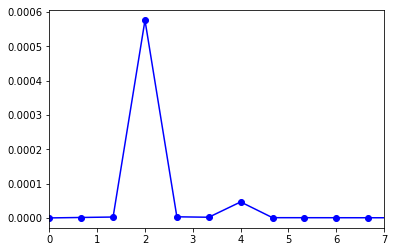

In [38]:
plt.figure()
plt.plot(sigM.Fvec,sigM.Mmag,'-ob')
plt.xlim((0, int(3.5*Freq)))